Device mapping: no known devices.
Iteración 0, Perdida: 2.4779e-01
Iteración 100, Perdida: 9.8182e-02
Iteración 200, Perdida: 8.1570e-02
Iteración 300, Perdida: 6.8829e-02
Iteración 400, Perdida: 6.2066e-02
Iteración 500, Perdida: 5.8680e-02
Iteración 600, Perdida: 5.5592e-02
Iteración 700, Perdida: 5.0217e-02
Iteración 800, Perdida: 4.0865e-02
Iteración 900, Perdida: 3.7790e-02
Iteración 1000, Perdida: 3.0551e-02
Iteración 1100, Perdida: 2.4694e-02
Iteración 1200, Perdida: 2.2241e-02
Iteración 1300, Perdida: 2.0476e-02
Iteración 1400, Perdida: 1.8534e-02
Iteración 1500, Perdida: 1.6503e-02
Iteración 1600, Perdida: 1.4364e-02
Iteración 1700, Perdida: 1.2975e-02
Iteración 1800, Perdida: 1.2178e-02
Iteración 1900, Perdida: 1.1644e-02
Iteración 2000, Perdida: 1.1086e-02
Iteración 2100, Perdida: 1.0540e-02
Iteración 2200, Perdida: 9.5334e-03
Iteración 2300, Perdida: 8.1420e-03
Iteración 2400, Perdida: 7.7417e-03
Iteración 2500, Perdida: 1.1552e-02
Iteración 2600, Perdida: 7.8674e-03
Iterac

C:\Users\Zotyx\AppData\Local\Temp\ipykernel_8972\75039176.py:214: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


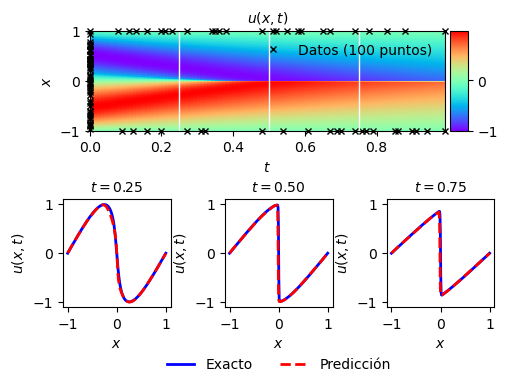

In [1]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

tf.compat.v1.disable_eager_execution()
np.random.seed(1234)
tf.random.set_seed(1234)

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                            
    inches_per_pt = 1.0/72.27                       
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale   
    fig_height = nplots*fig_width*golden_mean       
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

class PhysicsInformedNN:
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        self.weights, self.biases = self.initialize_NN(layers)
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                                         log_device_placement=True))
        
        self.x_u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
        self.optimizer = tf.compat.v1.train.AdamOptimizer().minimize(self.loss)
        
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))  # Función de activación
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            u = self.net_u(x, t)
            u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
    
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, iterations):
        for i in range(iterations):
            tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                       self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
            self.sess.run(self.optimizer, feed_dict=tf_dict)
            loss_value = self.sess.run(self.loss, feed_dict=tf_dict)
            
            if i % 100 == 0:
                print(f"Iteración {i}, Perdida: {loss_value:.4e}")
    
    def predict(self, X_star):
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:, 0:1], self.t_f_tf: X_star[:, 1:2]})
        return u_star, f_star
    
if __name__ == "__main__": 
     
    nu = 0.01/np.pi
    noise = 0.0        

    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    
    data = scipy.io.loadmat('../data/burgers_data.mat')
    
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0)    
        
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
        
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)
    
    start_time = time.time()                
    model.train(iterations=13000)
    elapsed = time.time() - start_time                
    print('Tiempo de Entrenamiento: %.4f' % (elapsed))
    
    u_pred, f_pred = model.predict(X_star)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))                     

    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    
    ######################################################################
    ############################# Grafica ################################
    ######################################################################    
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Grafica superior: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Datos (%d puntos)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    
    ####### Grafica inferior: u(t,x) instantes de tiempo ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exacto')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Predicción')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exacto')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Predicción')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exacto')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Predicción')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)
